# Classification Lab
### Data Preparation Part 1
<p class="lead">We have been tasked by <em>First Faux Union Bank</em> with developing an algorithm for classifying candidates more likely to sign up for a terms deposit based on historical data.  This <a href="https://jupyter.org/">Jupyter notebook</a>
shows our process for developing the classification model. </p>

<p></p>

<br>
<div class="alert alert-warning">
<b>Assignment:</b> Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis.<br><br>
Also, we got marked off last time for not talking about the business side of the mini lab even though the rubric did not mention it at all so we should probably include that in our Markdown as well.
</div>

In [54]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use(['seaborn-dark-palette'])

#Import dataset
df = pd.read_csv("bank-additional-full.csv", sep=";")

#View column names
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [55]:
df = df.drop(["duration"], axis=1)

> <p>It doesn't make sense to include the duration of the phone call for prediction purposes.  The call length is not something we will know in advance so we cannot use its value in a classifying model.</p>

In [56]:
df.columns[df.isnull().sum() > 0]

Index([], dtype='object')

> <p>Excellent! it looks like there are no null values to deal with.</p>

pandas.core.frame.DataFrame

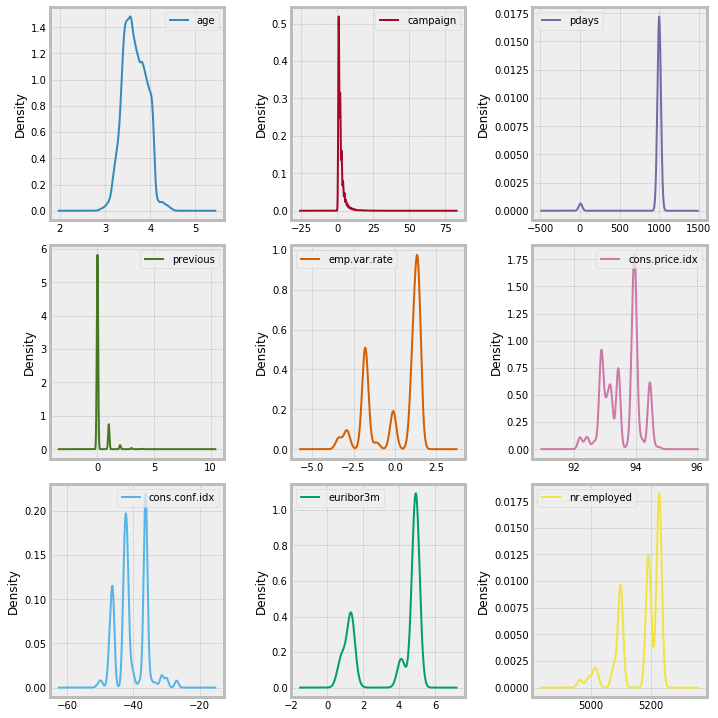

In [61]:
temp = df.groupby('y')

no = temp.get_group("no")
yes = temp.get_group("yes")


df.plot(kind='density', subplots=True, layout=(3,3), sharex=False, figsize=[10,10])

plt.tight_layout(pad=0.8, w_pad=1.8, h_pad=1.0)

type(no)


/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: FutureWarning: pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead
  """Entry point for launching an IPython kernel.


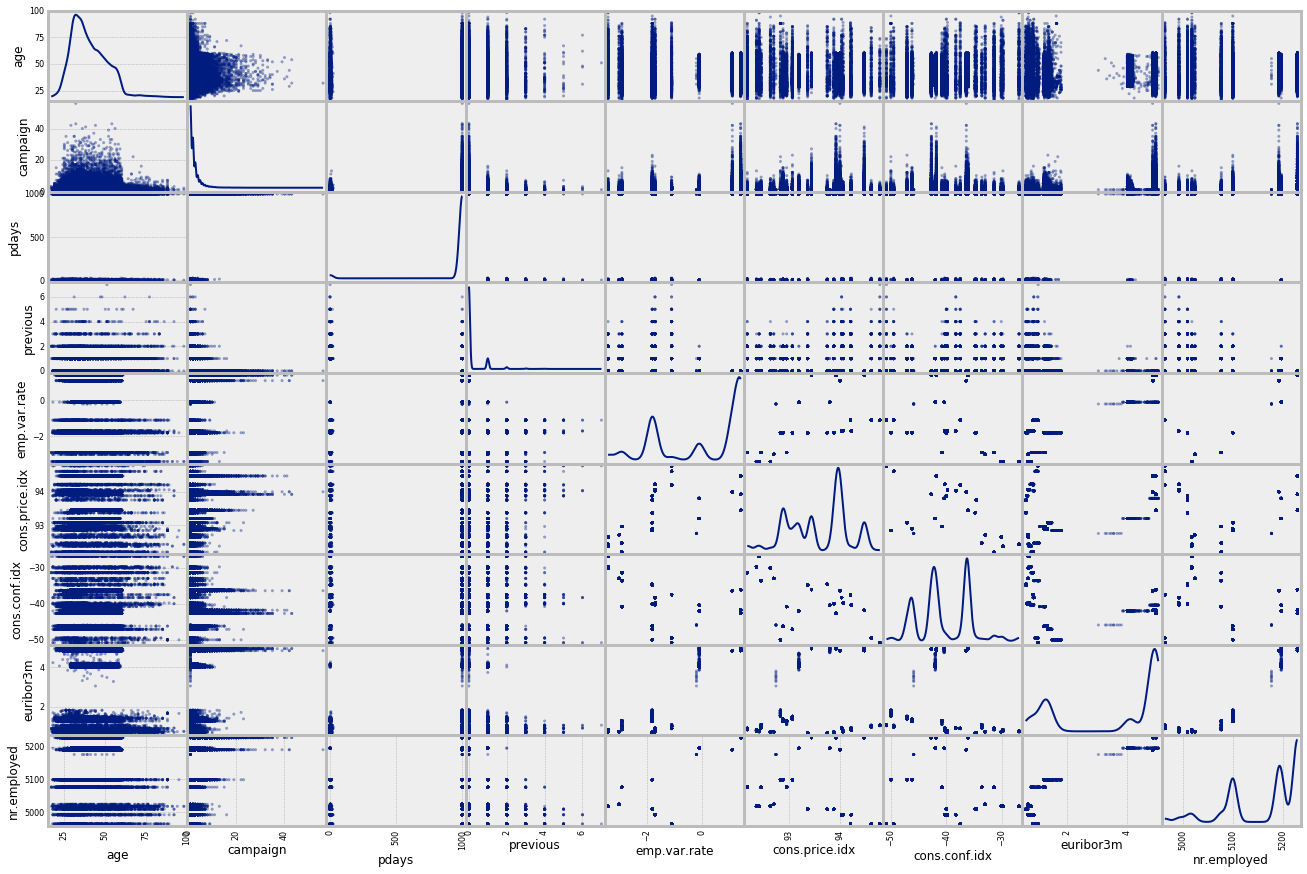

In [58]:
ax = pd.scatter_matrix(df, alpha=.4, diagonal="density", figsize=[20,15])
plt.show()

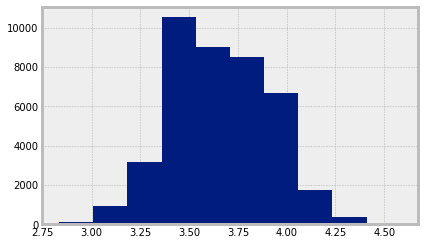

In [59]:
import numpy as np

df.age = df.age.apply(np.log)
df.age.hist()

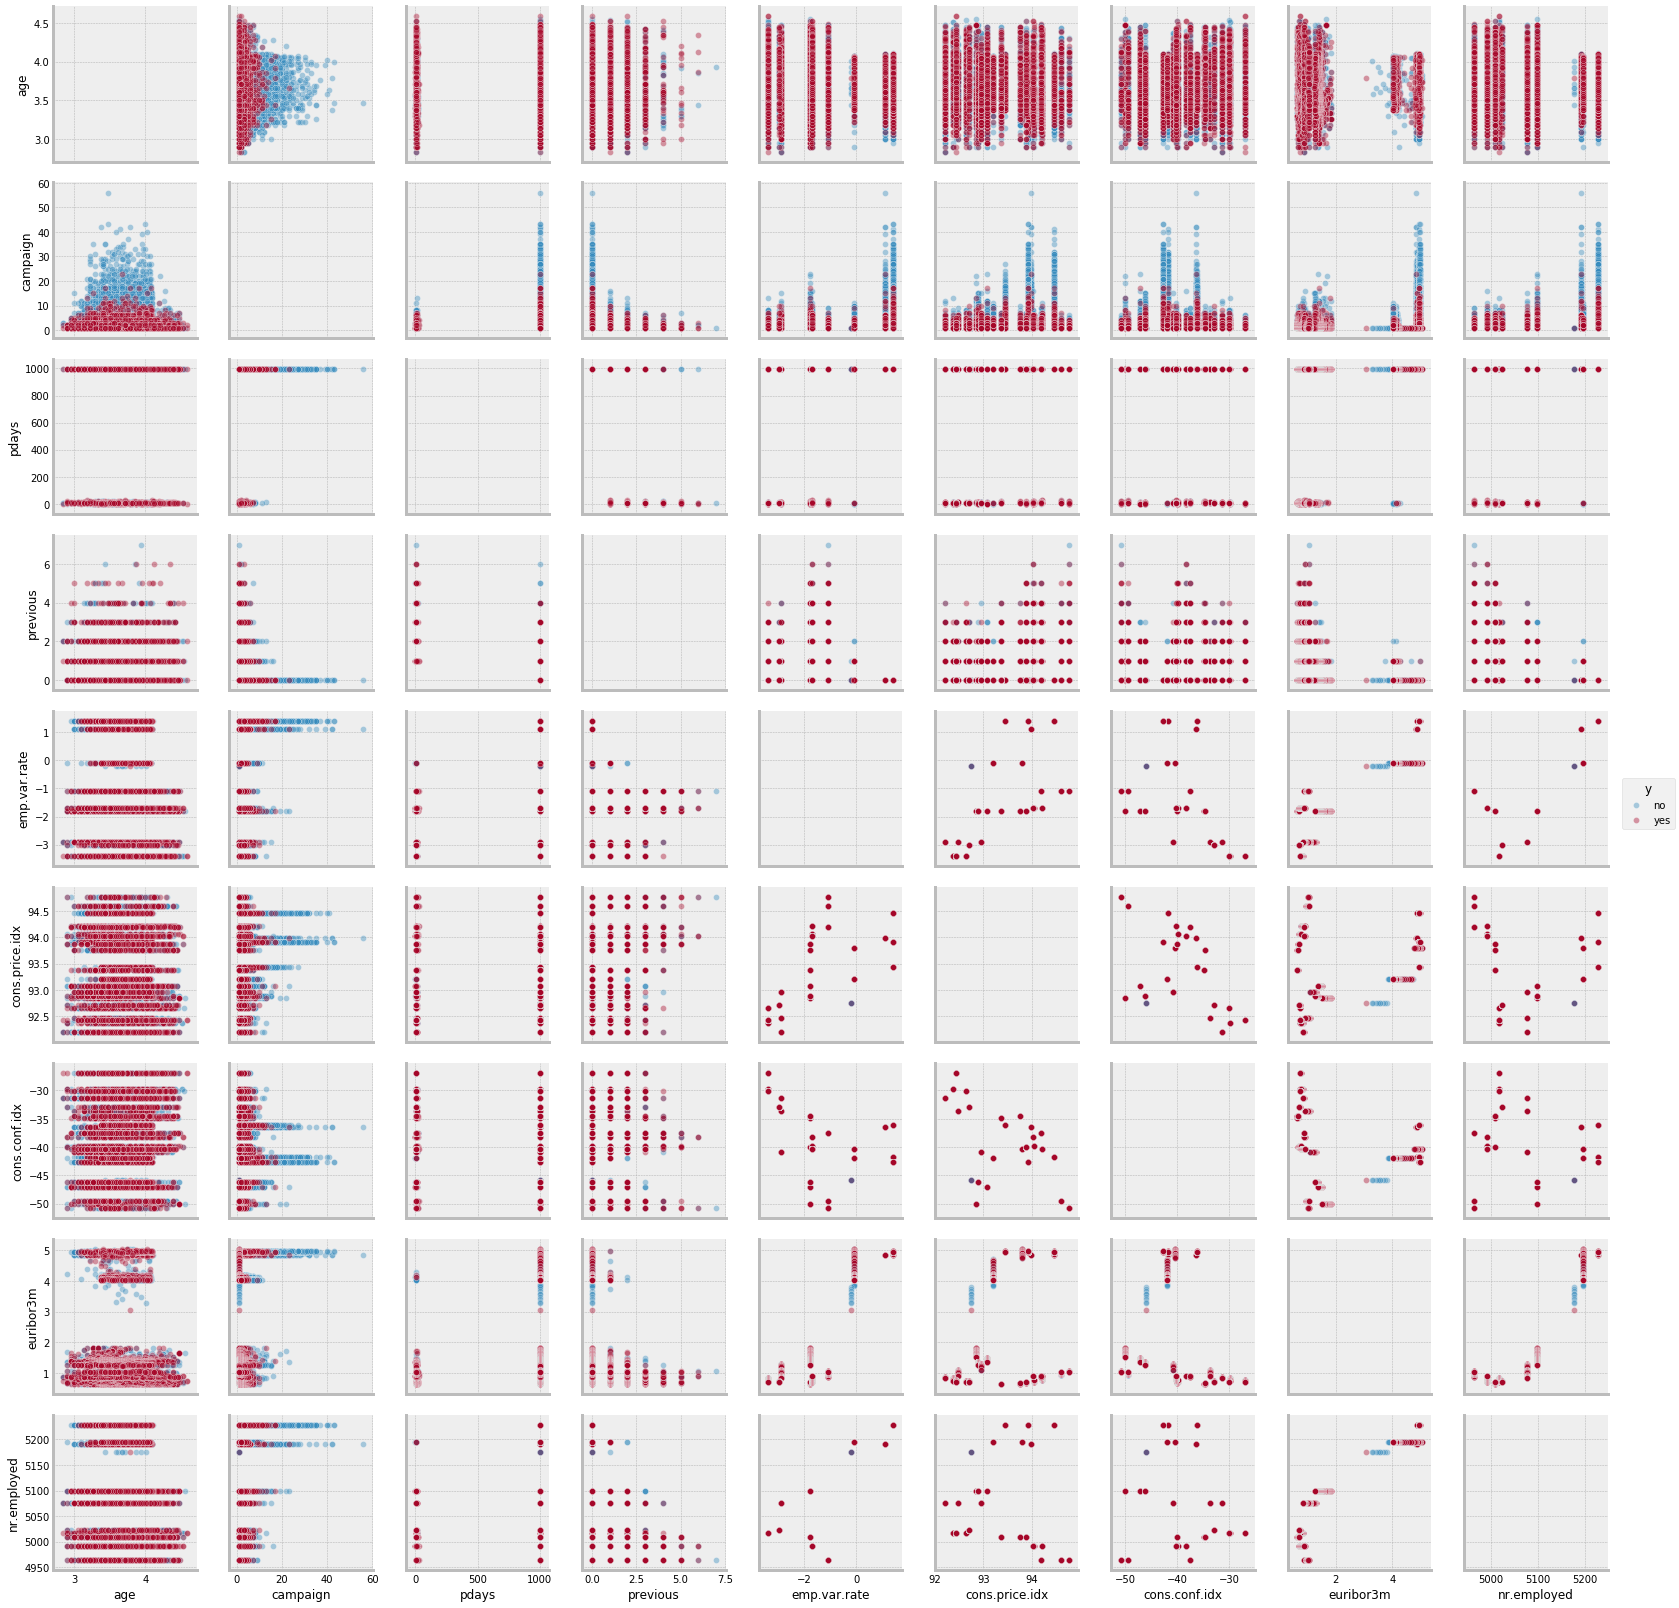

In [62]:
plt.style.use(['bmh'])
sns.pairplot(df, hue="y", diag_kind="kernel", plot_kws={"alpha":".4"})

> <p><b>Interpretation:</b> The pairplot above indicates that strong linear separation is most supported by age, campaign, whether or not the customer had previously signed up for the term deposit, and the current consumer confidence interval (CCI).</p>

In [ ]:
corr = df.corr()
plt.figure(figsize=[15,10])
sns.heatmap(corr,annot=True, fmt=".2%")

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

#get y
y = df.y

#get all but y, also drop duration as it is not suitable for prediction
X = df.drop(["y","duration"], axis=1)

# built in one hot encoding
X = pd.get_dummies(X)

In [ ]:
#split 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:

sns.set(style="ticks")

sns.pairplot(df, hue="y")

plt.show()

In [ ]:
from sklearn.decomposition import PCA

pca_attribs = PCA(n_components=6).fit_transform(X_train)

X_train_pca = pca_attribs

X_train_pca = pd.DataFrame(X_train_pca)

X_train_pca

### Data Preparation Part 2
<p></p>

<p></p>

<br>
<div class="alert alert-warning">
<b>Assignment:</b>Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created). </div>

### Modeling and Evaluation 1

<div class="alert alert-warning">
<b>Assignment:</b> Choose and explain your evaluation metrics that you will use (i.e., accuracy,
precision, recall, F-measure, or any metric we have discussed). Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertions.
</div>

### Modeling and Evaluation 2

<div class="alert alert-warning">
<b>Assignment:</b>Choose the method you will use for dividing your data into training and
testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why
your chosen method is appropriate or use more than one method as appropriate. For example, if you are using time series data then you should be using continuous training and testing sets across time.
</div>	

### Modeling and Evaluation 2

<div class="alert alert-warning">
<b>Assignment:</b>Choose the method you will use for dividing your data into training and
testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why
your chosen method is appropriate or use more than one method as appropriate. For example, if you are using time series data then you should be using continuous training and testing sets across time.
</div>	

### Modeling and Evaluation 3

<div class="alert alert-warning">
<b>Assignment:</b>Create three different classification/regression models for each task (e.g., random forest, KNN, and SVM for task one and the same or different algorithms for task two). Two modeling techniques must be new (but the third could be SVM or logistic regression). Adjust parameters as appropriate to increase generalization performance using your chosen metric. You must investigate different parameters of the algorithms!
</div>




### Modeling and Evaluation 4

<div class="alert alert-warning">
<b>Assignment:</b>Analyze the results using your chosen method of evaluation. Use visualizations of the results to bolster the analysis. Explain any visuals and analyze why they are interesting to someone that might use this model.
</div>	


### Modeling and Evaluation 5

<div class="alert alert-warning">
<b>Assignment:</b>Discuss the advantages of each model for each classification task, if any. If there are not advantages, explain why. Is any model better than another? Is the difference significant with 95% confidence? Use proper statistical comparison methods. You must use statistical comparison techniques—be sure they are appropriate for your chosen method of validation as discussed in unit 7 of the course.
</div>	

### Modeling and Evaluation 6

<div class="alert alert-warning">
<b>Assignment:</b>Which attributes from your analysis are most important? Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesize about why certain attributes are more important than others for a given classification task.
</div>	

### Deployment

<div class="alert alert-warning">
<b>Assignment:</b>How useful is your model for interested parties (i.e., the companies or organizations that might want to use it for prediction)? How would you measure the model's value if it was used by these parties? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.?
</div>	

### Exceptional Work

<div class="alert alert-warning">
<b>Assignment:</b>You have free reign to provide additional analyses. One idea: grid search parameters in a parallelized fashion and visualize the performances across attributes. Which parameters are most significant for making a good model for each classification algorithm?
</div>	